<a href="https://colab.research.google.com/github/leandro095/GIS-Heatmap-popolazione-ferrovie/blob/main/Ferrovie_Popolazione_1951_e_1971.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
import mapclassify as mc
import matplotlib.pyplot as plt

In [ ]:
# 1. Carica GeoJSON
comuni = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/HEATMAPS/file_italia/limits_IT_municipalities.geojson')
regioni = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/HEATMAPS/file_italia/limits_IT_regions.geojson')
ferrovie = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/HEATMAPS/file_italia/ferrovie_con_secondarie.geojson')

In [ ]:
print(comuni.columns)

Index(['name', 'op_id', 'name_de', 'name_sl', 'minint_elettorale',
       'minint_finloc', 'name_it', 'prov_name', 'prov_istat_code',
       'prov_istat_code_num', 'prov_acr', 'reg_name', 'reg_istat_code',
       'reg_istat_code_num', 'opdm_id', 'com_catasto_code', 'com_istat_code',
       'com_istat_code_num', 'geometry'],
      dtype='object')


In [ ]:
print(ferrovie.columns)

Index(['name', 'name:en', 'railway', 'ele', 'operator:type', 'layer',
       'addr:full', 'addr:city', 'source', 'name:it', 'osm_id', 'osm_type',
       'nome', 'anno chiusura', 'geometry'],
      dtype='object')


In [ ]:
# 2. Carica Excel popolazione pulita
pop = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/HEATMAPS/file_italia/Popolazione residente - Serie storica (IT1,DF_DCSS_POPRES_SERIES_TV_1,1.0).csv.xlsx')
pop = pop[['REF_AREA', 'TIME_PERIOD', 'OBS_VALUE']].rename(
    columns={'REF_AREA':'cod_istat', 'TIME_PERIOD':'anno', 'OBS_VALUE':'popolazione'}
)

In [ ]:
# Filter for the specific year
pop_1951 = pop[pop['anno'] == 1951].copy() # Ensure a copy to avoid SettingWithCopyWarning

# Filter out non-numeric cod_istat values (which are likely regional/provincial codes)
pop_1951 = pop_1951[pop_1951['cod_istat'].astype(str).str.isnumeric()]

# Pad numeric cod_istat values with leading zeros to match 6-digit municipal ISTAT codes
pop_1951['cod_istat'] = pop_1951['cod_istat'].astype(str).str.zfill(6)


In [ ]:
# Filter for the specific year
pop_1971 = pop[pop['anno'] == 1971].copy() # Ensure a copy to avoid SettingWithCopyWarning

# Filter out non-numeric cod_istat values (which are likely regional/provincial codes)
pop_1971 = pop_1971[pop_1971['cod_istat'].astype(str).str.isnumeric()]

# Pad numeric cod_istat values with leading zeros to match 6-digit municipal ISTAT codes
pop_1971['cod_istat'] = pop_1971['cod_istat'].astype(str).str.zfill(6)

In [ ]:
pop_1971.head()

cod_istat  anno  popolazione
2     001001  1971         2805
16    001002  1971         1501
30    001003  1971          524
44    001004  1971         1630
58    001006  1971         3920

In [ ]:
print(f"Il DataFrame pop_1971 ha {pop_1971.shape[0]} righe e {pop_1971.shape[1]} colonne.")

Il DataFrame pop_1971 ha 7914 righe e 3 colonne.


In [ ]:
# 3. JOIN popolazione ai comuni
comuni_pop = comuni.merge(pop_1971, left_on='com_istat_code', right_on='cod_istat', how='left')

In [ ]:
# Verifica quanti comuni non hanno popolazione dopo il merge
print("Quota comuni senza popolazione dopo il merge:", comuni_pop["popolazione"].isna().mean())

Quota comuni senza popolazione dopo il merge: 0.0007595898214963919


# MAPPA INTERATTIVA CHOROPLAT

In [ ]:
import folium

In [ ]:
# 4. MAPPA COMPLETA: regioni → comuni pop → ferrovie
m = regioni.explore(color='lightgray', name='Regioni')
m = comuni_pop.explore(m=m, column='popolazione', cmap='Blues',
                      alpha=0.7, legend=True, name='Comuni')
m = ferrovie.explore(m=m, color='red', linewidth=3, name='Ferrovie')

# Layer control
folium.LayerControl().add_to(m)
m

Buffered data was truncated after reaching the output size limit.

In [ ]:
# Salva
comuni_pop.to_file('/content/drive/MyDrive/Colab Notebooks/HEATMAPS/file_italia/comuni_1951_con_pop.geojson')

# HEATMAP INTERATTIVA

In [ ]:
# HEATMAP con geopandas
m = regioni.explore(color='lightgray')
m = comuni_pop.explore(
    m=m,
    column='popolazione',
    cmap='Blues',  # Rosso per alta popolazione
    scheme='quantiles',  # Dividi in 5 classi automatiche
    legend=True,
    alpha=0.8
)
ferrovie.explore(m=m, color='black', linewidth=2)

 # MAPPA STATICA IN ALTA QUALITà

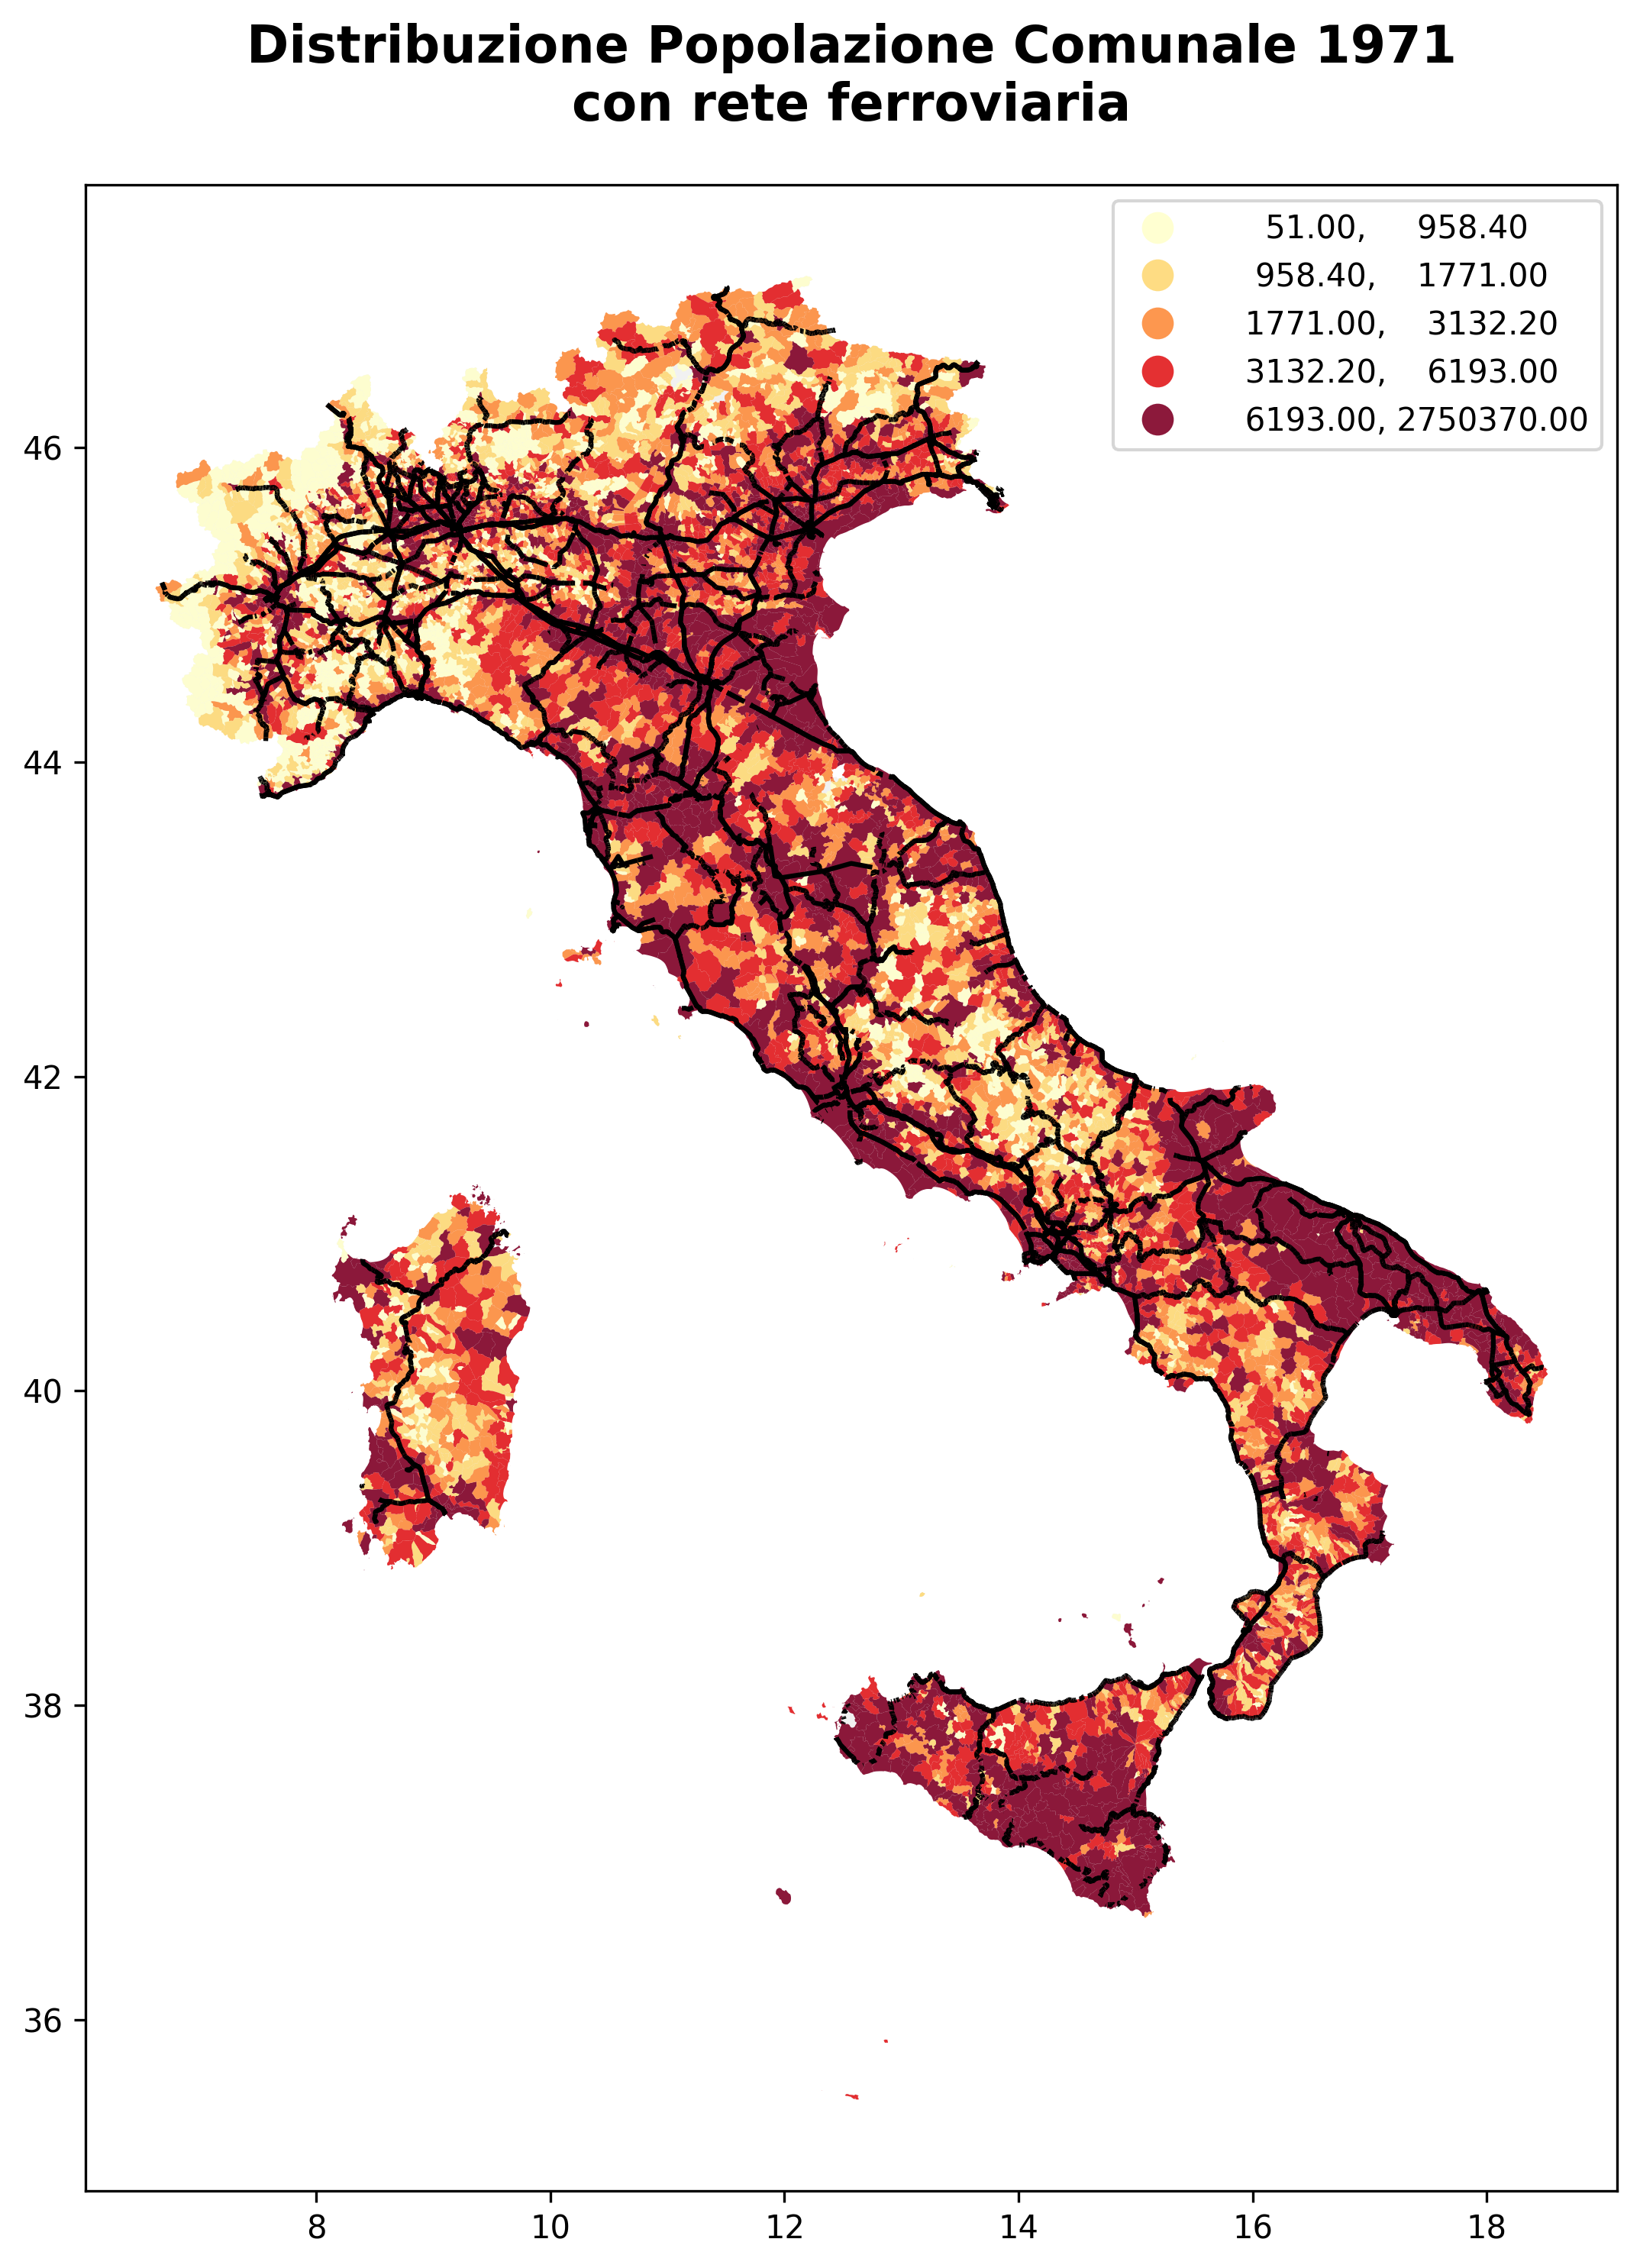

In [ ]:
fig, ax = plt.subplots(1, figsize=(12, 10), dpi=300)

# Sfondo regioni
regioni.plot(ax=ax, color='lightgray', linewidth=0.5, alpha=0.3)

# Heatmap comuni (giallo)
comuni_pop.plot(
    column='popolazione',
    cmap='YlOrRd',
    scheme='Quantiles',
    k=5,
    linewidth=0.1,
    alpha=0.9,
    legend=True,
    ax=ax
)

# Ferrovie in nero
ferrovie.plot(ax=ax, color='black', linewidth=1.5)

# Titolo
plt.title('Distribuzione Popolazione Comunale 1971\ncon rete ferroviaria',
          fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('heatmap_tesi.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

#ferrovie chiuse

In [ ]:
print(ferrovie['anno chiusura'].info())
print(ferrovie['anno chiusura'].value_counts(dropna=False))

<class 'pandas.core.series.Series'>
RangeIndex: 77878 entries, 0 to 77877
Series name: anno chiusura
Non-Null Count  Dtype 
--------------  ----- 
12 non-null     object
dtypes: object(1)
memory usage: 608.6+ KB
None
anno chiusura
None    77866
1948        2
1987        2
1927        1
1965        1
1923        1
1945        1
1966        1
1962        1
1960        1
1968        1
Name: count, dtype: int64


In [ ]:
ferrovie_chiuse = ferrovie[ferrovie['anno chiusura'].notna()].copy()
ferrovie_aperte = ferrovie[ferrovie['anno chiusura'].isna()].copy()

print(f"Number of closed railways: {len(ferrovie_chiuse)}")
print(f"Number of open railways: {len(ferrovie_aperte)}")

Number of closed railways: 12
Number of open railways: 77866


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import matplotlib.colors as colors
import mapclassify as mc
import matplotlib
import numpy as np
import re

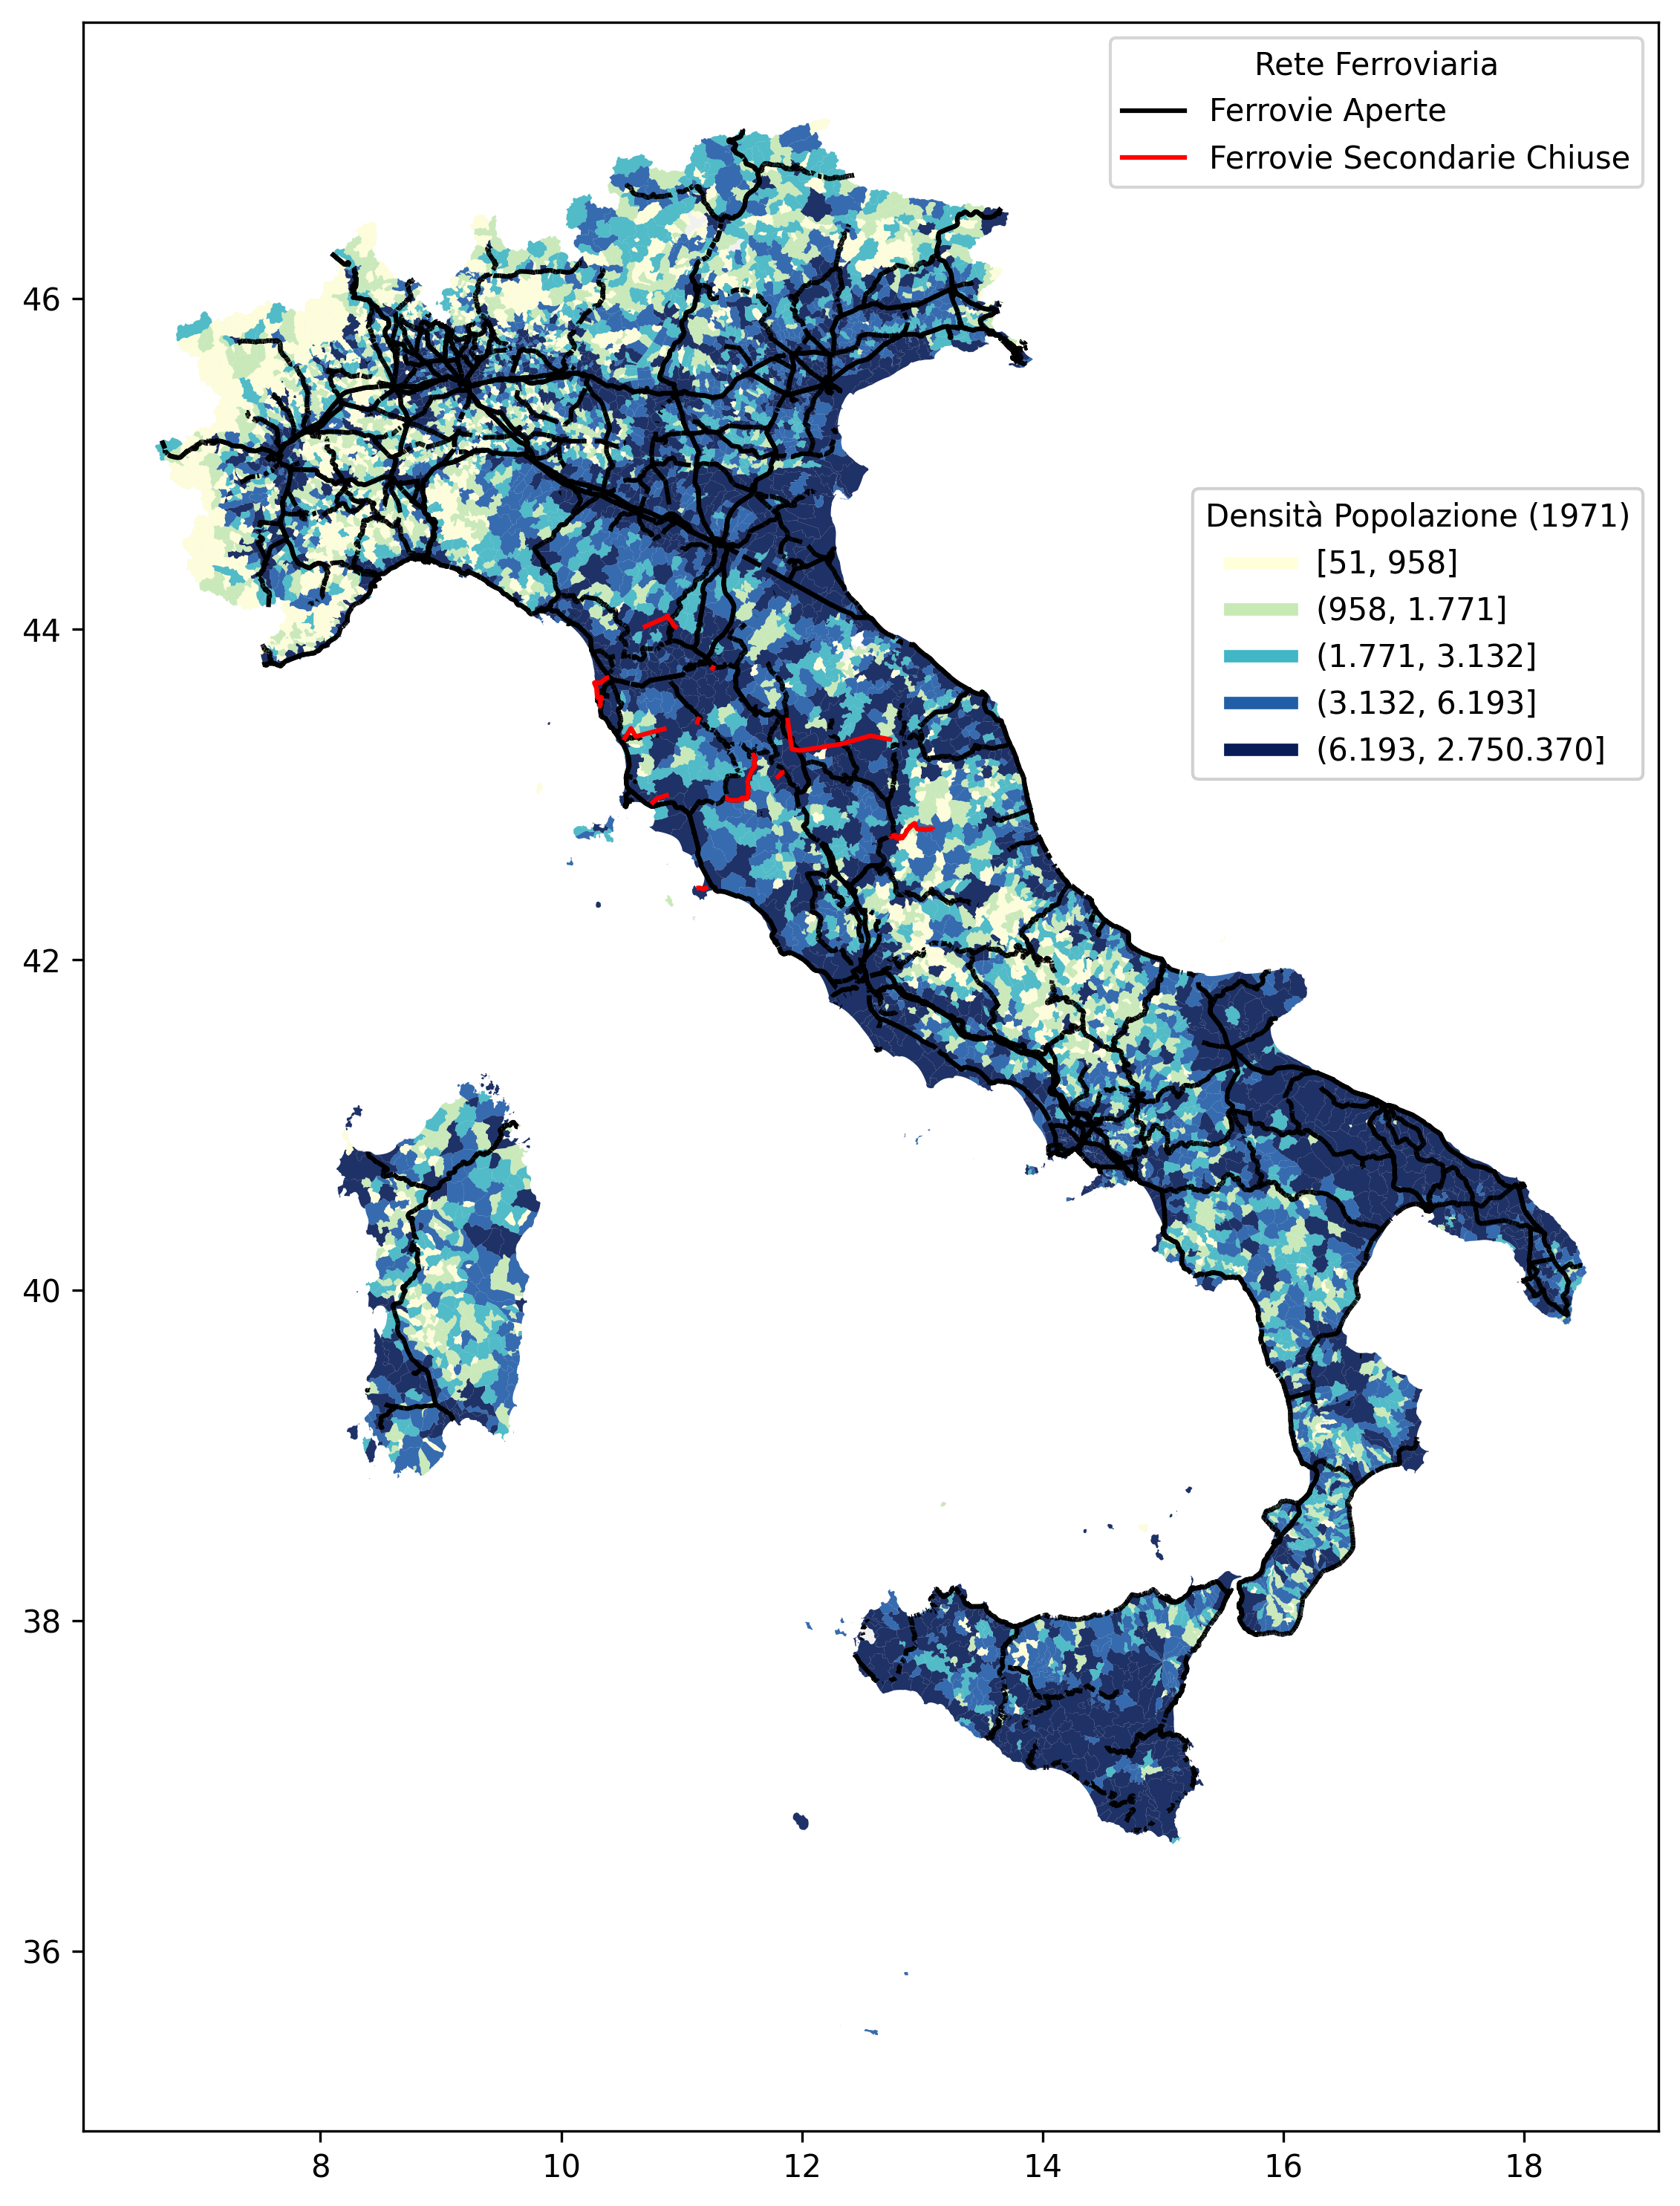

In [ ]:
fig, ax = plt.subplots(1, figsize=(12, 10), dpi=300)

# Imposto le regioni nel Plot
regioni.plot(ax=ax, color='lightgray', linewidth=0.5, alpha=0.3)

# Heatmap comuni (generazione della classificazione e plot senza legenda)
scheme = mc.Quantiles(comuni_pop['popolazione'].dropna(), k=5)
comuni_pop.plot(
    column='popolazione',
    cmap='YlGnBu',
    scheme='Quantiles',
    k=5,
    linewidth=0.1,
    alpha=0.9,
    legend=False, # Disabilitare la legenda automatica di geopandas
    ax=ax
)

# Formattazione del formato numeri con . per separare le migliaia
def format_thousands(number_str):
    if not number_str.strip():
        return number_str
    try:
        n = int(number_str)
        # Si utilizza Python's f-string per mettere _ come separatore delle migliaia
        # per poi rimpiazzarlo con il .
        return f'{n:_.0f}'.replace('_', '.')
    except ValueError:
        return number_str # Return as is if not a number

# Creazione manuale della legenda per la popolazione
population_legend_handles = []
cmap_pop = matplotlib.colormaps['YlGnBu'].resampled(scheme.k)

# Get the raw labels from mapclassify without thousands comma (fmt="{:.0f}")
raw_pop_labels = scheme.get_legend_classes(fmt="{:.0f}")

processed_pop_labels = []
for label_str in raw_pop_labels:
    # Regex to capture the opening bracket, first number string, second number string, and closing bracket
    match = re.match(r'([\(\[])\s*(.*?)\s*,\s*(.*?)\s*([\)\]])', label_str)
    if match:
        open_bracket = match.group(1)
        num1_str_raw = match.group(2)
        num2_str_raw = match.group(3)
        close_bracket = match.group(4)

        # Formattazione numeri con . come separatore delle migliaia
        num1_formatted = format_thousands(num1_str_raw)
        num2_formatted = format_thousands(num2_str_raw)


        processed_label = f"{open_bracket}{num1_formatted}, {num2_formatted}{close_bracket}"
        processed_pop_labels.append(processed_label)
    else:
        processed_pop_labels.append(label_str)

pop_labels = processed_pop_labels

# Estrazione corretta dei colori dalla colormap
colors_from_cmap = [cmap_pop(i) for i in np.linspace(0, 1, scheme.k)]

for i, label in enumerate(pop_labels):
    color = colors_from_cmap[i]
    population_legend_handles.append(Line2D([0], [0], color=color, lw=4, label=label))

# Ferrovie aperte in nero
ferrovie_aperte.plot(ax=ax, color='black', linewidth=1.5)

# Ferrovie chiuse in rosso
ferrovie_chiuse.plot(ax=ax, color='red', linewidth=1.5)

# Creazione della legenda customizzata per le linee ferroviarie
railway_legend_handles = [
    Line2D([0], [0], color='black', lw=1.5, label='Ferrovie Aperte'),
    Line2D([0], [0], color='red', lw=1.5, label='Ferrovie Secondarie Chiuse')
]

# Legenda delle ferrovie in alto a destra
railway_legend = ax.legend(handles=railway_legend_handles, loc='upper right', title='Rete Ferroviaria', frameon=True, bbox_to_anchor=(1.0, 1.0))
ax.add_artist(railway_legend)

# bbox della legenda delle ferrovie e sue coordinate nella figura
# Calcolo anche la y position per la legenda della popolazione che metto sotto
fig.canvas.draw() # Force a draw to ensure get_window_extent is accurate
railway_legend_bbox = railway_legend.get_window_extent().transformed(fig.transFigure.inverted())

# aggiungo un piccolo padding tra le legende
padding = 0.02

# Calcolo la posizione y per la legenda della population bbox
y_pos_for_population_legend = railway_legend_bbox.y0 - padding

# Aggiungo population legend (sotto railway legend)
population_legend = ax.legend(handles=population_legend_handles, loc='upper right', title='Densità Popolazione (1971)', frameon=True, bbox_to_anchor=(1.0, y_pos_for_population_legend))
ax.add_artist(population_legend)

# Titolo
#plt.title('Distribuzione Popolazione Comunale 1971\ncon rete ferroviaria',
          #fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('heatmap_tesi_ferrovie.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()